### **NASDAQ-Adjusted Demand Forecasting**
This analysis explores the relationship between Avnet's weekly shipment demand and fluctuations in the NASDAQ index. By estimating the sensitivity of demand to market changes, it simulates adjusted forecasts under varying market conditions and compares them with actual performance to assess improvement potential.

### **Data Sources:**

1.   NASDAQCOM
2.   NASDAQCOM (2)




Week t+1 forecast: 1,265,436
Week t+2 forecast: 1,272,378
Week t+3 forecast: 1,241,680
Week t+4 forecast: 1,865,225
Week t+5 forecast: 2,173,416
Week t+6 forecast: 1,688,807
Week t+7 forecast: 2,112,206
Week t+8 forecast: 1,758,477
Week t+9 forecast: 2,539,904
Week t+10 forecast: 1,743,707
Week t+11 forecast: 1,213,548
Week t+12 forecast: 1,101,272
Week t+13 forecast: 2,028,328
Week t+14 forecast: 1,643,050
Week t+15 forecast: 1,878,037
Week t+16 forecast: 1,940,400
Week t+17 forecast: 1,333,453
Week t+18 forecast: 1,094,537
Week t+19 forecast: 1,115,080
Week t+20 forecast: 1,609,053
Week t+21 forecast: 1,304,341


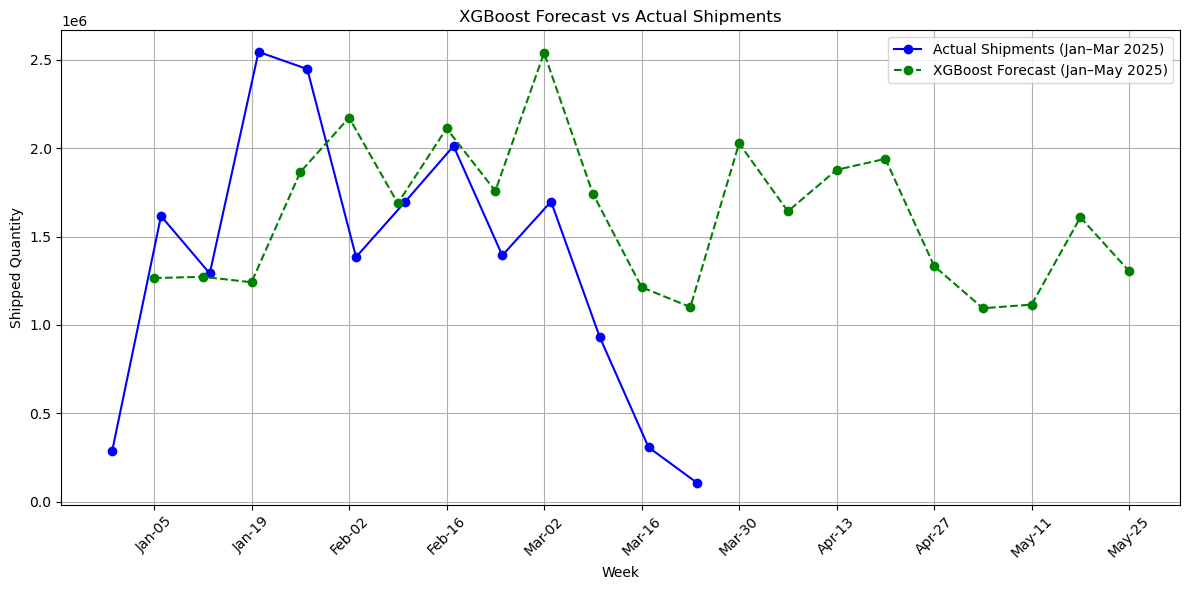


Model Performance:
MAPE (Jan–Mar 2025): 2.0500
RMSE (Jan–Mar 2025): 768,209.04


In [9]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error

# Load the shipment data
file_path = (r"C:\Users\balbi\OneDrive\CAPSTONE\ASU Forecast\ASU Forecast\Historical Demand (Shipments) Capstone Data(result).csv")
df = pd.read_csv(file_path)

# Convert the date column to datetime format
df['Customer_Required_Date_CRD'] = pd.to_datetime(df['Customer_Required_Date_CRD'], format='%m/%d/%Y')

# Use only 2023 and 2024 data to train the model
df_train = df[df['Customer_Required_Date_CRD'] < '2025-01-01']

# Group the data by week and calculate total shipped quantity
weekly = df_train.groupby(df_train['Customer_Required_Date_CRD'].dt.to_period('W'))['Shipped_Qty'].sum()
weekly = weekly.to_timestamp().reset_index()
weekly.rename(columns={'Customer_Required_Date_CRD': 'Week_Start'}, inplace=True)

# Create time-based features
weekly['Week'] = weekly['Week_Start'].dt.isocalendar().week
weekly['Month'] = weekly['Week_Start'].dt.month
weekly['Quarter'] = weekly['Week_Start'].dt.quarter

# Add lag features (previous week's data) and rolling average
for lag in range(1, 6):
    weekly[f'Lag{lag}'] = weekly['Shipped_Qty'].shift(lag)

# Add rolling average of the last 3 weeks
weekly['RollingMean3'] = weekly['Shipped_Qty'].rolling(3).mean().shift(1)

# Remove rows that have missing values due to lag/rolling
weekly.dropna(inplace=True)
weekly.reset_index(drop=True, inplace=True)

# Prepare to predict the next 21 weeks (multi-step forecasting)
horizon = 21
for step in range(1, horizon + 1):
    weekly[f'target_t+{step}'] = weekly['Shipped_Qty'].shift(-step)

# Remove rows with missing targets
weekly.dropna(inplace=True)
weekly.reset_index(drop=True, inplace=True)

# Select the input features
features = ['Week', 'Month', 'Quarter', 'Lag1', 'Lag2', 'Lag3', 'Lag4', 'Lag5', 'RollingMean3']
X = weekly[features]

# Select the target columns (next 21 weeks)
y_multi = weekly[[f'target_t+{i}' for i in range(1, horizon + 1)]]

# Make sure we have enough data to train
if len(X) < 2:
    raise ValueError("Not enough data to train. Please use full 2023 and 2024 data.")

# Use all but the last row for training, and the last row to make future predictions
X_train, X_test = X.iloc[:-1], X.iloc[[-1]]
y_train = y_multi.iloc[:-1]

# Initialize dictionary to store models and list to store forecasts
models = {}
forecasts = []

# Train 21 models (one for each future week)
for i in range(horizon):
    target_col = f'target_t+{i+1}'
    model = XGBRegressor(n_estimators=200, learning_rate=0.05, max_depth=4, random_state=42)
    model.fit(X_train, y_train[target_col])
    pred = model.predict(X_test)[0]
    models[target_col] = model
    forecasts.append(pred)
    print(f"Week t+{i+1} forecast: {pred:,.0f}")

# Create weekly dates for Jan to May 2025
forecast_dates = pd.date_range(start='2025-01-01', periods=horizon, freq='W')

# Store predictions with their dates
forecast_series = pd.Series(forecasts, index=forecast_dates)

# Get actual shipment data for Jan to Mar 2025 for comparison
df_actual = df[(df['Customer_Required_Date_CRD'] >= '2025-01-01') &
               (df['Customer_Required_Date_CRD'] <= '2025-03-31')]
actual_weekly = df_actual.groupby(df_actual['Customer_Required_Date_CRD'].dt.to_period('W'))['Shipped_Qty'].sum().to_timestamp()

# Align forecast and actual data for evaluation
aligned_actuals = actual_weekly[:len(forecast_series)]
aligned_forecasts = forecast_series[:len(aligned_actuals)]

# Calculate MAPE and RMSE for evaluation
mape = mean_absolute_percentage_error(aligned_actuals, aligned_forecasts)
rmse = np.sqrt(mean_squared_error(aligned_actuals, aligned_forecasts))

# Plot the forecast vs actual
plt.figure(figsize=(12, 6))
plt.plot(actual_weekly, label='Actual Shipments (Jan–Mar 2025)', marker='o', color='blue')
plt.plot(forecast_series, label='XGBoost Forecast (Jan–May 2025)', linestyle='--', marker='o', color='green')
plt.xticks(forecast_series.index[::2], forecast_series.index[::2].strftime('%b-%d'), rotation=45)
plt.title("XGBoost Forecast vs Actual Shipments")
plt.xlabel("Week")
plt.ylabel("Shipped Quantity")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Print how good the model is
print("\nModel Performance:")
print(f"MAPE (Jan–Mar 2025): {mape:.4f}")
print(f"RMSE (Jan–Mar 2025): {rmse:,.2f}")


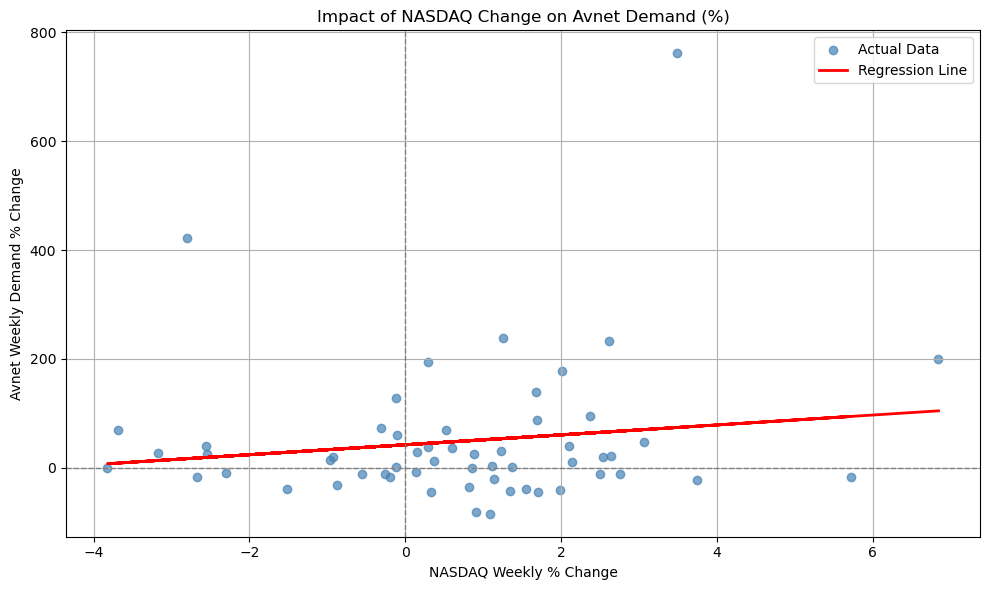

Sensitivity Coefficient: 9.11
Intercept: 42.08


In [10]:
# Import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

# Load NASDAQ data
nasdaq_data = pd.read_csv(r"C:\Users\balbi\OneDrive\CAPSTONE\ASU Forecast\ASU Forecast\Nasdaq\NASDAQCOM.csv")
nasdaq_data['observation_date'] = pd.to_datetime(nasdaq_data['observation_date'])

# Weekly NASDAQ average prices (each week starts on Monday)
nasdaq_weekly = nasdaq_data.resample('W-MON', on='observation_date')['NASDAQCOM'].mean().reset_index()
nasdaq_weekly.rename(columns={'observation_date': 'Week_Start', 'NASDAQCOM': 'NASDAQ_Close'}, inplace=True)

# Load Avnet shipment data
avnet_data = pd.read_csv(r"C:\Users\balbi\OneDrive\CAPSTONE\ASU Forecast\ASU Forecast\Historical Demand (Shipments) Capstone Data(result).csv")
avnet_data['Customer_Required_Date_CRD'] = pd.to_datetime(avnet_data['Customer_Required_Date_CRD'], errors='coerce')

# Weekly Avnet demand
avnet_weekly = (
    avnet_data.groupby(avnet_data['Customer_Required_Date_CRD'].dt.to_period('W'))['Shipped_Qty']
    .sum()
    .to_timestamp()
    .reset_index()
    .rename(columns={'Customer_Required_Date_CRD': 'Week_Start', 'Shipped_Qty': 'Avnet_Demand'})
)

# Merge NASDAQ and Avnet data on weekly dates
combined_df = pd.merge(avnet_weekly, nasdaq_weekly, on='Week_Start', how='inner')

# Calculate week-over-week percent changes
combined_df['Avnet_Change_Pct'] = combined_df['Avnet_Demand'].pct_change() * 100
combined_df['NASDAQ_Change_Pct'] = combined_df['NASDAQ_Close'].pct_change() * 100

# Remove rows with missing values from percent change
combined_df.dropna(inplace=True)

# Prepare data for regression
X = combined_df[['NASDAQ_Change_Pct']]
y = combined_df['Avnet_Change_Pct']

# Train the regression model
reg = LinearRegression()
reg.fit(X, y)

# Get the regression line
x_vals = X['NASDAQ_Change_Pct']
y_vals = reg.predict(X)

# Plot the relationship
plt.figure(figsize=(10, 6))
plt.scatter(x_vals, y, label='Actual Data', color='steelblue', alpha=0.7)
plt.plot(x_vals, y_vals, color='red', linewidth=2, label='Regression Line')
plt.axhline(0, color='grey', linestyle='--', linewidth=1)
plt.axvline(0, color='grey', linestyle='--', linewidth=1)
plt.title('Impact of NASDAQ Change on Avnet Demand (%)')
plt.xlabel('NASDAQ Weekly % Change')
plt.ylabel('Avnet Weekly Demand % Change')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Print regression results
print(f"Sensitivity Coefficient: {reg.coef_[0]:.2f}")
print(f"Intercept: {reg.intercept_:.2f}")


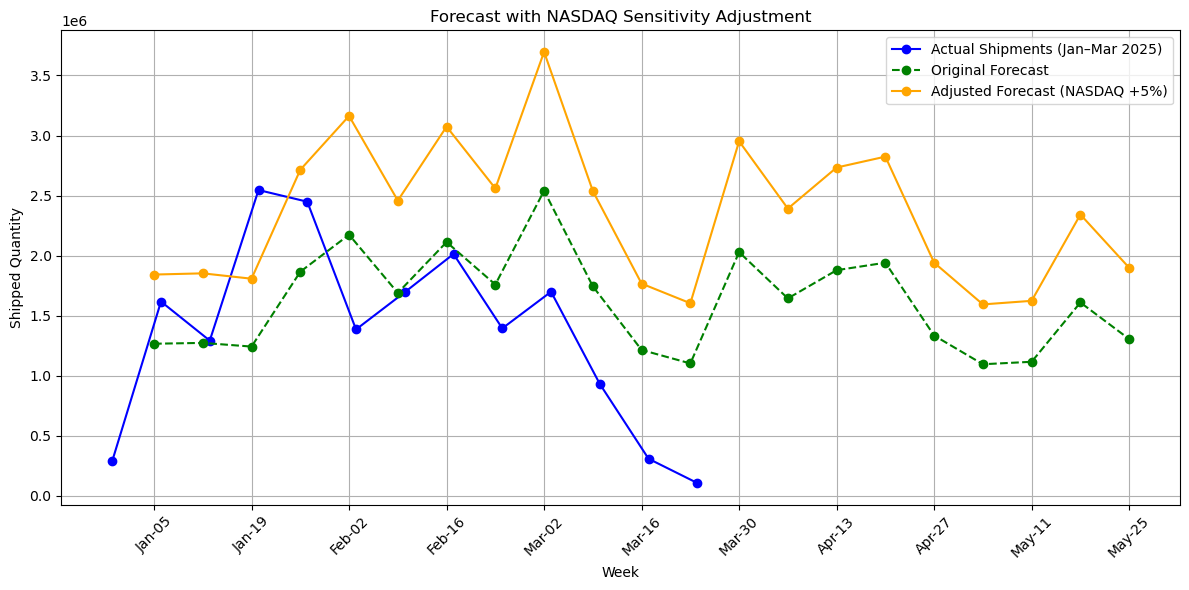

,Week,Original Forecast,Adjusted Forecast (NASDAQ +5%)
2025-01-05,2025-01-05,1265436,1841696
2025-01-12,2025-01-12,1272378,1851799
2025-01-19,2025-01-19,1241680,1807123
2025-01-26,2025-01-26,1865225,2714620
2025-02-02,2025-02-02,2173416,3163157
2025-02-09,2025-02-09,1688807,2457864
2025-02-16,2025-02-16,2112206,3074073
2025-02-23,2025-02-23,1758477,2559260
2025-03-02,2025-03-02,2539904,3696537
2025-03-09,2025-03-09,1743707,2537765



Model Performance (Jan–Mar 2025):
Sensitivity Coefficient: 9.11
MAPE: 2.0500
RMSE: 768,209.04


In [11]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error
from IPython.display import display

# --- Load NASDAQ data ---
nasdaq_df = pd.read_csv(r"C:\Users\balbi\OneDrive\CAPSTONE\ASU Forecast\ASU Forecast\Nasdaq\NASDAQCOM.csv")
nasdaq_df['observation_date'] = pd.to_datetime(nasdaq_df['observation_date'])
nasdaq_weekly = nasdaq_df.resample('W-MON', on='observation_date')['NASDAQCOM'].mean().reset_index()
nasdaq_weekly.rename(columns={'observation_date': 'Week_Start', 'NASDAQCOM': 'NASDAQ_Close'}, inplace=True)

# --- Aggregate Avnet shipment data by week ---
avnet_df = df.copy()  # assuming `df` is already loaded earlier
avnet_weekly = (
    avnet_df.groupby(avnet_df['Customer_Required_Date_CRD'].dt.to_period('W'))['Shipped_Qty']
    .sum().to_timestamp().reset_index()
)
avnet_weekly.rename(columns={'Customer_Required_Date_CRD': 'Week_Start', 'Shipped_Qty': 'Avnet_Demand'}, inplace=True)

# --- Merge NASDAQ and Avnet data ---
merged_df = pd.merge(avnet_weekly, nasdaq_weekly, on='Week_Start', how='inner')
merged_df['Avnet_Change_Pct'] = merged_df['Avnet_Demand'].pct_change() * 100
merged_df['NASDAQ_Change_Pct'] = merged_df['NASDAQ_Close'].pct_change() * 100
merged_df.dropna(inplace=True)

# --- Calculate sensitivity coefficient from regression ---
X = merged_df[['NASDAQ_Change_Pct']]
y = merged_df['Avnet_Change_Pct']
reg_model = LinearRegression().fit(X, y)
sensitivity_coef = reg_model.coef_[0]

# --- Simulate NASDAQ-driven demand adjustment ---
nasdaq_change_percent = 5  # Adjust this to simulate positive/negative NASDAQ movement
demand_change_multiplier = 1 + (sensitivity_coef * nasdaq_change_percent / 100)
adjusted_forecast_series = forecast_series * demand_change_multiplier  # assumes `forecast_series` is defined

# --- Get actual data for Jan–Mar 2025 ---
df_actual = df[(df['Customer_Required_Date_CRD'] >= '2025-01-01') &
               (df['Customer_Required_Date_CRD'] <= '2025-03-31')]
actual_weekly = df_actual.groupby(df_actual['Customer_Required_Date_CRD'].dt.to_period('W'))['Shipped_Qty'].sum().to_timestamp()

# --- Evaluate original forecast vs actuals ---
aligned_actual = actual_weekly[:len(forecast_series)]
aligned_forecast = forecast_series[:len(aligned_actual)]
mape = mean_absolute_percentage_error(aligned_actual, aligned_forecast)
rmse = np.sqrt(mean_squared_error(aligned_actual, aligned_forecast))

# --- Plot forecasts ---
plt.figure(figsize=(12, 6))
plt.plot(actual_weekly, label='Actual Shipments (Jan–Mar 2025)', color='blue', marker='o')
plt.plot(forecast_series, label='Original Forecast', linestyle='--', color='green', marker='o')
plt.plot(adjusted_forecast_series, label=f'Adjusted Forecast (NASDAQ {nasdaq_change_percent:+}%)', color='orange', marker='o')
plt.xticks(forecast_series.index[::2], forecast_series.index[::2].strftime('%b-%d'), rotation=45)
plt.title("Forecast with NASDAQ Sensitivity Adjustment")
plt.xlabel("Week")
plt.ylabel("Shipped Quantity")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# --- Forecast comparison table ---
comparison_df = pd.DataFrame({
    'Week': forecast_series.index.strftime('%Y-%m-%d'),
    'Original Forecast': forecast_series.round().astype(int),
    f'Adjusted Forecast (NASDAQ {nasdaq_change_percent:+}%)': adjusted_forecast_series.round().astype(int)
})
display(comparison_df)

# --- Print model performance ---
print("\nModel Performance (Jan–Mar 2025):")
print(f"Sensitivity Coefficient: {sensitivity_coef:.2f}")
print(f"MAPE: {mape:.4f}")
print(f"RMSE: {rmse:,.2f}")


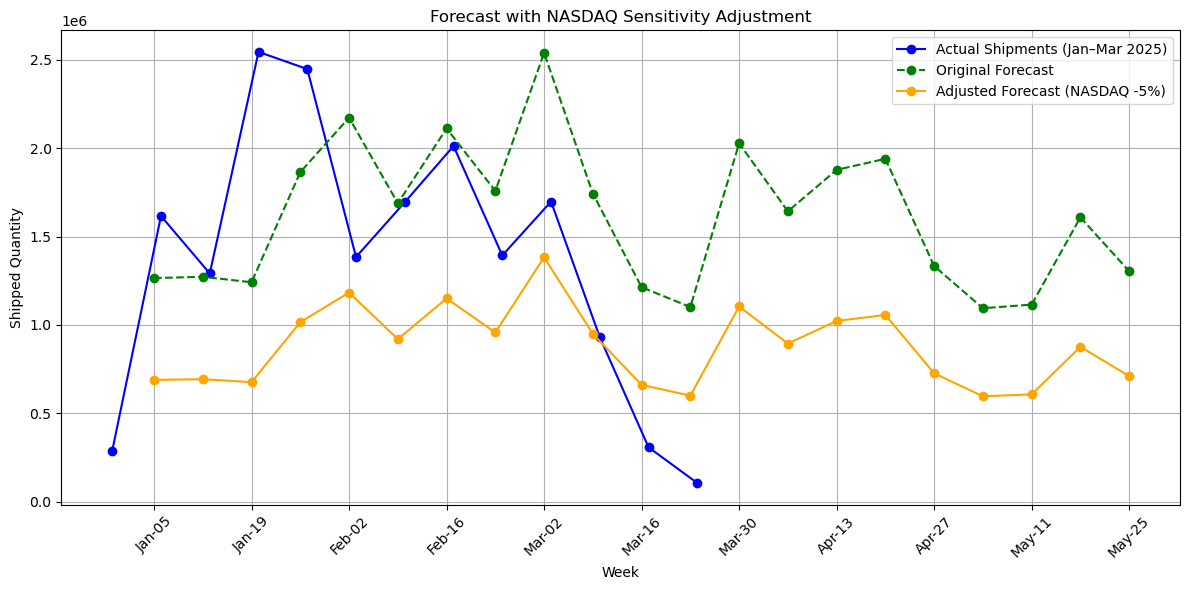

,Week,Original Forecast,Adjusted Forecast (NASDAQ -5%)
2025-01-05,2025-01-05,1265436,689030
2025-01-12,2025-01-12,1272378,692810
2025-01-19,2025-01-19,1241680,676095
2025-01-26,2025-01-26,1865225,1015615
2025-02-02,2025-02-02,2173416,1183425
2025-02-09,2025-02-09,1688807,919555
2025-02-16,2025-02-16,2112206,1150096
2025-02-23,2025-02-23,1758477,957491
2025-03-02,2025-03-02,2539904,1382978
2025-03-09,2025-03-09,1743707,949448



Forecast Evaluation (Jan–Mar 2025):
Sensitivity Coefficient: 9.11
MAPE: 2.0500
RMSE: 768,209.04


In [12]:
#--- Simulate NASDAQ impact on forecast ---
sensitivity_coef = 9.11  # Sensitivity from prior regression (already calculated)
nasdaq_change_percent = -5  # Simulate a 5% NASDAQ drop
adjustment_factor = 1 + (sensitivity_coef * nasdaq_change_percent / 100)
adjusted_forecast = forecast_series * adjustment_factor  # forecast_series assumed precomputed

#--- Aggregate actual shipment data for Jan–Mar 2025---
actual_data = df[
    (df['Customer_Required_Date_CRD'] >= '2025-01-01') &
    (df['Customer_Required_Date_CRD'] <= '2025-03-31')
]
actual_weekly = actual_data.groupby(actual_data['Customer_Required_Date_CRD'].dt.to_period('W'))['Shipped_Qty'].sum().to_timestamp()

#--- Evaluate original forecast (Jan–Mar)---
aligned_actual = actual_weekly[:len(forecast_series)]
aligned_forecast = forecast_series[:len(aligned_actual)]
mape = mean_absolute_percentage_error(aligned_actual, aligned_forecast)
rmse = np.sqrt(mean_squared_error(aligned_actual, aligned_forecast))

#--- Plot actual, original, and adjusted forecast---
plt.figure(figsize=(12, 6))
plt.plot(actual_weekly, label='Actual Shipments (Jan–Mar 2025)', marker='o', color='blue')
plt.plot(forecast_series, label='Original Forecast', linestyle='--', marker='o', color='green')
plt.plot(adjusted_forecast, label=f'Adjusted Forecast (NASDAQ {nasdaq_change_percent:+}%)', marker='o', color='orange')
plt.xticks(forecast_series.index[::2], forecast_series.index[::2].strftime('%b-%d'), rotation=45)
plt.title("Forecast with NASDAQ Sensitivity Adjustment")
plt.xlabel("Week")
plt.ylabel("Shipped Quantity")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

#--- Display comparison table---
comparison_df = pd.DataFrame({
    'Week': forecast_series.index.strftime('%Y-%m-%d'),
    'Original Forecast': forecast_series.round().astype(int),
    f'Adjusted Forecast (NASDAQ {nasdaq_change_percent:+}%)': adjusted_forecast.round().astype(int)
})
display(comparison_df)

#--- Print evaluation results---
print("\nForecast Evaluation (Jan–Mar 2025):")
print(f"Sensitivity Coefficient: {sensitivity_coef:.2f}")
print(f"MAPE: {mape:.4f}")
print(f"RMSE: {rmse:,.2f}")


,Week,Original Forecast,NASDAQ Change %,Adjusted Forecast
2025-01-13,2025-01-13,1265436,-1.45,1097963
2025-01-20,2025-01-20,1272378,0.40,1318285
2025-01-27,2025-01-27,1241680,2.28,1499745
2025-02-03,2025-02-03,1865225,-1.06,1685409
2025-02-10,2025-02-10,2173416,0.32,2235791
2025-02-17,2025-02-17,1688807,0.72,1799340
2025-02-24,2025-02-24,2112206,-0.21,2071040
2025-03-03,2025-03-03,1758477,-5.08,943926
2025-03-10,2025-03-10,2539904,-3.49,1733181
2025-03-17,2025-03-17,1743707,-2.89,1283949


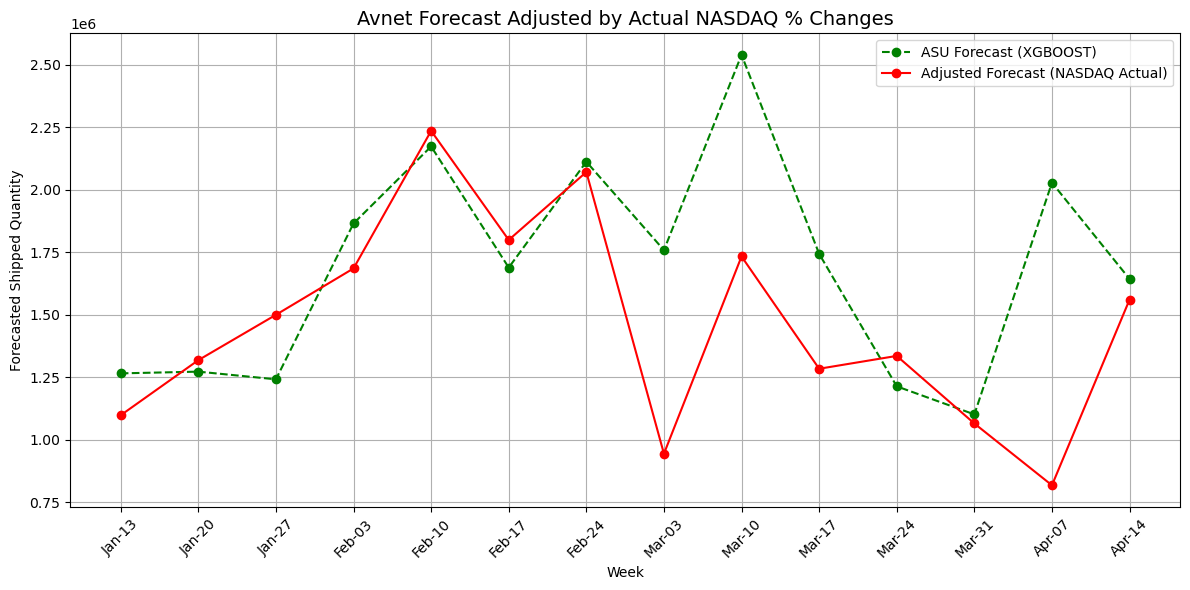

In [13]:
import pandas as pd
import matplotlib.pyplot as plt

#--- Load the NASDAQ CSV file (manually download and place in working directory) ---
nasdaq_path =r"C:\Users\balbi\OneDrive\CAPSTONE\ASU Forecast\ASU Forecast\Nasdaq\NASDAQCOM (2).csv"  # Replace with your actual file name
nasdaq_df = pd.read_csv(nasdaq_path)

#--- Rename and parse date ---
nasdaq_df['observation_date'] = pd.to_datetime(nasdaq_df['observation_date'])
nasdaq_df.rename(columns={'observation_date': 'Week_Start', 'NASDAQCOM': 'NASDAQ_Close'}, inplace=True)

#--- Resample to weekly (Monday) ---
nasdaq_weekly = nasdaq_df.resample('W-MON', on='Week_Start')['NASDAQ_Close'].mean().reset_index()
nasdaq_weekly['NASDAQ_Change_%'] = nasdaq_weekly['NASDAQ_Close'].pct_change() * 100
nasdaq_weekly.dropna(inplace=True)

#--- Define your 14-week XGBoost forecast (replace with your actual model output if available) ---
forecast_series = pd.Series(
    [1265436, 1272378, 1241680, 1865225, 2173416, 1688807, 2112206,
     1758477, 2539904, 1743707, 1213548, 1101272, 2028328, 1643050],
    index=pd.date_range(start='2025-01-13', periods=14, freq='W-MON')
)

#--- Align NASDAQ changes with forecast weeks ---
nasdaq_aligned = nasdaq_weekly.set_index('Week_Start').loc[forecast_series.index]
nasdaq_changes = nasdaq_aligned['NASDAQ_Change_%'].values

#--- Apply the sensitivity coefficient ---
sensitivity_coef = 9.11
adjusted_forecast = forecast_series * (1 + (sensitivity_coef * nasdaq_changes / 100))

#--- Create comparison table ---
forecast_comparison = pd.DataFrame({
    'Week': forecast_series.index.strftime('%Y-%m-%d'),
    'Original Forecast': forecast_series.round(0).astype(int),
    'NASDAQ Change %': nasdaq_changes.round(2),
    'Adjusted Forecast': adjusted_forecast.round(0).astype(int)
})

# Display the table
from IPython.display import display
display(forecast_comparison)

#--- Plot original vs adjusted forecast ---
plt.figure(figsize=(12, 6))
plt.plot(forecast_series.index, forecast_series, label='ASU Forecast (XGBOOST)', linestyle='--', marker='o', color='green')
plt.plot(forecast_series.index, adjusted_forecast, label='Adjusted Forecast (NASDAQ Actual)', marker='o', color='red')
plt.title("Avnet Forecast Adjusted by Actual NASDAQ % Changes", fontsize=14)
plt.xlabel("Week")
plt.ylabel("Forecasted Shipped Quantity")
plt.xticks(forecast_series.index, forecast_series.index.strftime('%b-%d'), rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

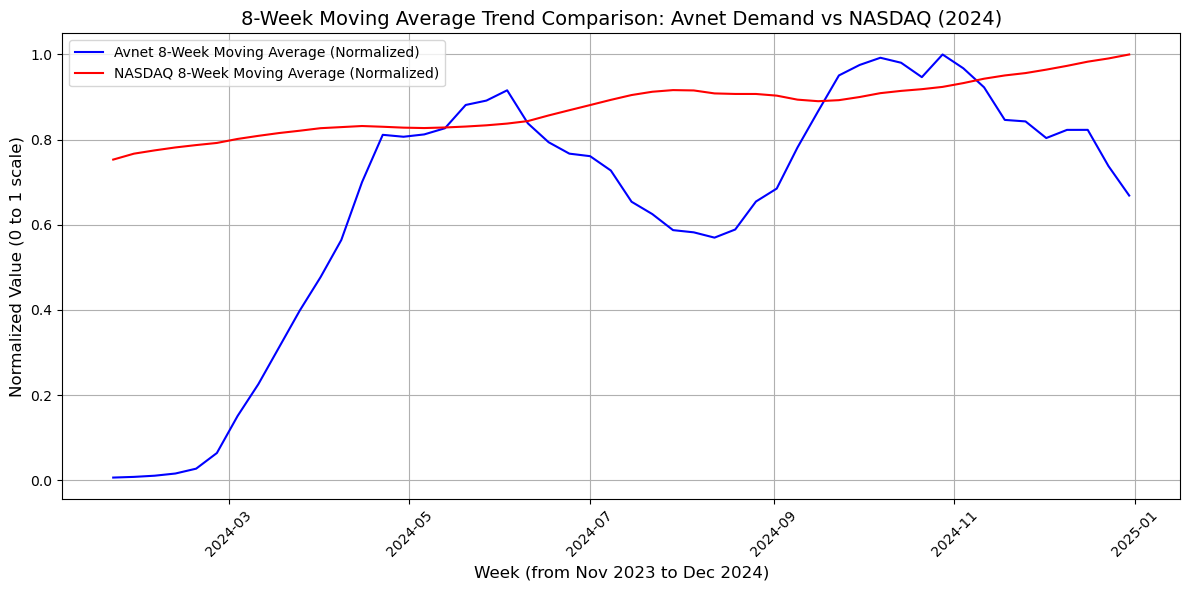

In [15]:
import pandas as pd
import matplotlib.pyplot as plt

# Load data
df_demand = pd.read_csv(r"C:\Users\balbi\OneDrive\CAPSTONE\ASU Forecast\ASU Forecast\Historical Demand (Shipments) Capstone Data(result).csv")
df_nasdaq = pd.read_csv(r"C:\Users\balbi\OneDrive\CAPSTONE\ASU Forecast\ASU Forecast\Nasdaq\NASDAQCOM.csv")

# Preprocess demand data
df_demand['Customer_Required_Date_CRD'] = pd.to_datetime(df_demand['Customer_Required_Date_CRD'])
df_demand = df_demand[(df_demand['Customer_Required_Date_CRD'] >= '2023-11-01') &
                      (df_demand['Customer_Required_Date_CRD'] <= '2024-12-31')]

# Group by week
avnet_weekly = df_demand.groupby(df_demand['Customer_Required_Date_CRD'].dt.to_period('W'))['Shipped_Qty'].sum()
avnet_weekly = avnet_weekly.to_timestamp().reset_index()
avnet_weekly.rename(columns={'Customer_Required_Date_CRD': 'Week_Start'}, inplace=True)

# Preprocess NASDAQ data
df_nasdaq['observation_date'] = pd.to_datetime(df_nasdaq['observation_date'])
nasdaq_weekly = df_nasdaq.resample('W-MON', on='observation_date')['NASDAQCOM'].mean().reset_index()
nasdaq_weekly.rename(columns={'observation_date': 'Week_Start', 'NASDAQCOM': 'NASDAQ_Close'}, inplace=True)

# Filter NASDAQ to same period
nasdaq_weekly = nasdaq_weekly[(nasdaq_weekly['Week_Start'] >= '2023-11-01') &
                               (nasdaq_weekly['Week_Start'] <= '2024-12-31')]

# Merge datasets
merged = pd.merge(avnet_weekly, nasdaq_weekly, on='Week_Start', how='inner')

# Compute 8-week moving averages
merged['Avnet_8W_MA'] = merged['Shipped_Qty'].rolling(8).mean()
merged['NASDAQ_8W_MA'] = merged['NASDAQ_Close'].rolling(8).mean()

# Normalize for comparison
merged['Avnet_8W_MA_Norm'] = merged['Avnet_8W_MA'] / merged['Avnet_8W_MA'].max()
merged['NASDAQ_8W_MA_Norm'] = merged['NASDAQ_8W_MA'] / merged['NASDAQ_8W_MA'].max()

# Plot
plt.figure(figsize=(12, 6))
plt.plot(merged['Week_Start'], merged['Avnet_8W_MA_Norm'], label='Avnet 8-Week Moving Average (Normalized)', color='blue')
plt.plot(merged['Week_Start'], merged['NASDAQ_8W_MA_Norm'], label='NASDAQ 8-Week Moving Average (Normalized)', color='red')
plt.title("8-Week Moving Average Trend Comparison: Avnet Demand vs NASDAQ (2024)", fontsize=14)
plt.xlabel("Week (from Nov 2023 to Dec 2024)", fontsize=12)
plt.ylabel("Normalized Value (0 to 1 scale)", fontsize=12)
plt.grid(True)
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
